# Machine Learning Model Building Pipeline: Big Data, Images and Neural Networks


## Imports

In [67]:
import pandas as pd 
import numpy as np

# navigate folders
from glob import glob
import os

# for plotting 
import matplotlib.pyplot as plt 
%matplotlib inline

# to open the images 
import cv2 

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# data preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# evaluate model and separate train and test
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# for the convolutional network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam 
from keras.metrics import categorical_crossentropy 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  
from keras.utils import np_utils

## Load Images / Data

In [68]:
# here are all our images
DATA_FOLDER = 'v2-plant-seedlings-dataset'

In [69]:
# each weed class is in a dedicated folder
os.listdir(DATA_FOLDER)

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'nonsegmentedv2',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [70]:
# let's wal over the directory structure, so we understand hot the images are stored

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_name = os.path.join(DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_name, "*.png")):
        print(image_path)

v2-plant-seedlings-dataset\Black-grass\1.png
v2-plant-seedlings-dataset\Black-grass\10.png
v2-plant-seedlings-dataset\Black-grass\100.png
v2-plant-seedlings-dataset\Black-grass\101.png
v2-plant-seedlings-dataset\Black-grass\102.png
v2-plant-seedlings-dataset\Black-grass\103.png
v2-plant-seedlings-dataset\Black-grass\104.png
v2-plant-seedlings-dataset\Black-grass\105.png
v2-plant-seedlings-dataset\Black-grass\106.png
v2-plant-seedlings-dataset\Black-grass\107.png
v2-plant-seedlings-dataset\Black-grass\108.png
v2-plant-seedlings-dataset\Black-grass\109.png
v2-plant-seedlings-dataset\Black-grass\11.png
v2-plant-seedlings-dataset\Black-grass\110.png
v2-plant-seedlings-dataset\Black-grass\111.png
v2-plant-seedlings-dataset\Black-grass\112.png
v2-plant-seedlings-dataset\Black-grass\113.png
v2-plant-seedlings-dataset\Black-grass\114.png
v2-plant-seedlings-dataset\Black-grass\115.png
v2-plant-seedlings-dataset\Black-grass\116.png
v2-plant-seedlings-dataset\Black-grass\117.png
v2-plant-seedling

In [71]:
# lets crate a dataframe:
# the datframe stores the path to the image in a one column
# and the class of the weed (the target) in the next column

images_df = []

# navigate within each folder
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)

    # collect every image path
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

print(images_df)
# concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

[                                              0            1
0  v2-plant-seedlings-dataset\Black-grass\1.png  Black-grass,                                                0            1
0  v2-plant-seedlings-dataset\Black-grass\10.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\100.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\101.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\102.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\103.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\104.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\105.png  Bl

,image,target
0,v2-plant-seedlings-dataset\Black-grass\1.png,Black-grass
1,v2-plant-seedlings-dataset\Black-grass\10.png,Black-grass
2,v2-plant-seedlings-dataset\Black-grass\100.png,Black-grass
3,v2-plant-seedlings-dataset\Black-grass\101.png,Black-grass
4,v2-plant-seedlings-dataset\Black-grass\102.png,Black-grass
5,v2-plant-seedlings-dataset\Black-grass\103.png,Black-grass
6,v2-plant-seedlings-dataset\Black-grass\104.png,Black-grass
7,v2-plant-seedlings-dataset\Black-grass\105.png,Black-grass
8,v2-plant-seedlings-dataset\Black-grass\106.png,Black-grass
9,v2-plant-seedlings-dataset\Black-grass\107.png,Black-grass


In [72]:
# hoy many images do we've got per class?
# this should give similar results to what we observed
# when we inspected the length of image list in the dictionary

# There is class imbalance, but we will ignore it.

images_df['target'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherds Purse              274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

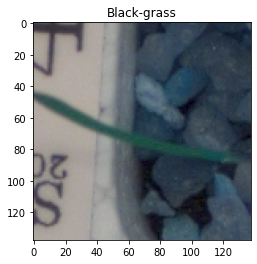

In [73]:
# let's visualise a few images
# if the iamges you see in your notebook are not the same, don't

def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)

plot_single_image(images_df, 0)

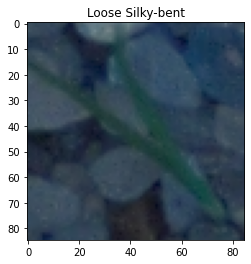

In [74]:
plot_single_image(images_df, 3000)

In [75]:
# let's go ahead and plot a bunch of our images together,
# so we get a better feeling of how our images look like

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3

    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])
            axs[i, j].imshow(im)
            n += 1

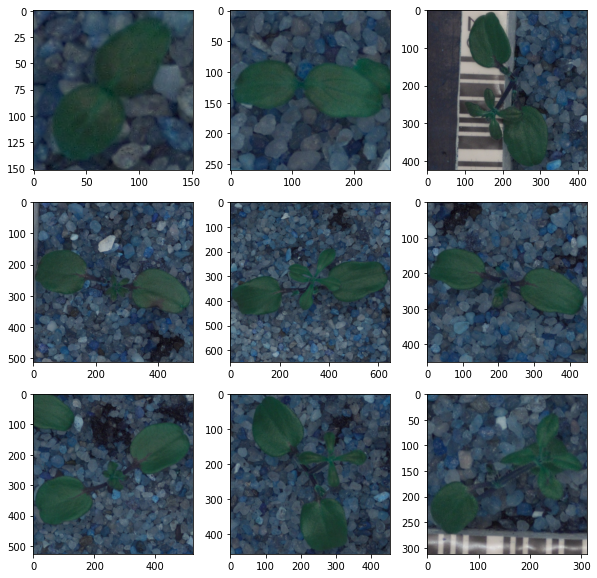

In [76]:
plot_for_class(images_df, 'Cleavers')

## Separate train and test

In [77]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_df['image'], images_df['target'], test_size=0.20, random_state=101)

print(X_train.shape)
print(X_test.shape)

(4431,)
(1108,)


In [78]:
# the indeces of the training data are mixed
# this will cause problems later

X_train.head()

1922      v2-plant-seedlings-dataset\Common wheat\204.png
4164    v2-plant-seedlings-dataset\Scentless Mayweed\5...
2952    v2-plant-seedlings-dataset\Loose Silky-bent\43...
287          v2-plant-seedlings-dataset\Black-grass\8.png
4971    v2-plant-seedlings-dataset\Small-flowered Cran...
Name: image, dtype: object

In [79]:
# reset index, because later we iterate over row number

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train.head()

0      v2-plant-seedlings-dataset\Common wheat\204.png
1    v2-plant-seedlings-dataset\Scentless Mayweed\5...
2    v2-plant-seedlings-dataset\Loose Silky-bent\43...
3         v2-plant-seedlings-dataset\Black-grass\8.png
4    v2-plant-seedlings-dataset\Small-flowered Cran...
Name: image, dtype: object

In [80]:
# reset index in target as well

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [81]:
# percentage of images within each class

s = y_train.value_counts() / len(y_train)

In [82]:
# let's prepare the target
# it is a multiclass classification, so we need to make
# one hot encoding of the target

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [83]:
# The iamges in our folders, are all different sizes
# For neural networks however, we need images in the same size
# The images will all be resized to this size:

IMAGE_SIZE = 150

In [84]:
def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [85]:
tmp = im_resize(X_train, 7)
tmp.shape

(150, 150, 3)

In [86]:
# the shape of the datasets need to be(n1, n2, n3, n4)
# where n1 is the number of observations
# n2 and n3 are image width and length
# and n4 indicates that it is color image, so 3 planes per image

def create_dataset(df, image_size):
    # functions creates dataset as required for cnn
    tmp = np.zeros((len(df), image_size, image_size,3), dtype='float32')

    for n in range(0, len(df)):
        im = im_resize(df, n)
        tmp[n] = im 
    
    print('Dataset Images shape: {} size: {:,}'.format(tmp.shape, tmp.size))
    return tmp

In [87]:
x_train = create_dataset(X_train, IMAGE_SIZE)

Dataset Images shape: (4431, 150, 150, 3) size: 299,092,500


In [88]:
x_test = create_dataset(X_test, IMAGE_SIZE)

Dataset Images shape: (1108, 150, 150, 3) size: 74,790,000


In [89]:
len(y_train.unique())

12

In [90]:
kernel_size = (3,3)
pool_size = (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(Conv2D(second_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(Conv2D(third_filters, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 34, 34, 64)       

In [91]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
batch_size = 10
epochs = 8

In [109]:
# Care with this takes saveral hours

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=1,
                              verbose=1, mode='max', min_lr=0.00001)


callbacks_list = [checkpoint, reduce_lr]

history = model.fit(x=x_train, y=train_y,
                    batch_size=batch_size,
                    validation_split=0.10,
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks_list)


Epoch 1/8
399/399 - 303s - loss: 0.1079 - accuracy: 0.7690 - val_loss: 0.1044 - val_accuracy: 0.7883

Epoch 00001: accuracy improved from -inf to 0.76900, saving model to model.h5
Epoch 2/8
399/399 - 296s - loss: 0.0915 - accuracy: 0.8114 - val_loss: 0.1121 - val_accuracy: 0.7725

Epoch 00002: accuracy improved from 0.76900 to 0.81139, saving model to model.h5
Epoch 3/8
399/399 - 282s - loss: 0.0786 - accuracy: 0.8427 - val_loss: 0.1113 - val_accuracy: 0.7523

Epoch 00003: accuracy improved from 0.81139 to 0.84274, saving model to model.h5
Epoch 4/8
399/399 - 312s - loss: 0.0730 - accuracy: 0.8573 - val_loss: 0.0965 - val_accuracy: 0.8018

Epoch 00004: accuracy improved from 0.84274 to 0.85729, saving model to model.h5
Epoch 5/8
399/399 - 267s - loss: 0.0608 - accuracy: 0.8916 - val_loss: 0.0876 - val_accuracy: 0.8311

Epoch 00005: accuracy improved from 0.85729 to 0.89165, saving model to model.h5
Epoch 6/8
399/399 - 284s - loss: 0.0536 - accuracy: 0.9039 - val_loss: 0.0956 - val_accu

KeyboardInterrupt: 

In [111]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

NameError: name 'history' is not defined

In [112]:
# make a prediction

predictions = model.predict_classes(x_test, verbose=1)

35/35 [==============================] - 18s 515ms/step


In [113]:
# inspect predictions
predictions

array([ 6,  6, 11, ..., 11,  3,  4], dtype=int64)

In [114]:
# transform target
encoder.transform(y_test)

array([ 6,  0, 11, ...,  6,  3,  3])

In [115]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

In [116]:
# create a dict to map back the numbers onto the classes

tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values, index=tmp.class_number).to_dict()
tmp

{6: 'Loose Silky-bent',
 0: 'Black-grass',
 11: 'Sugar beet',
 3: 'Common Chickweed',
 2: 'Cleavers',
 9: 'Shepherds Purse',
 1: 'Charlock',
 8: 'Scentless Mayweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 10: 'Small-flowered Cranesbill',
 7: 'Maize'}

In [117]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

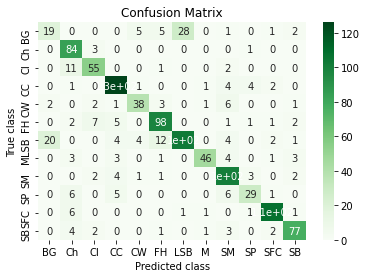

In [119]:
import seaborn as sns

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show()

In [131]:
from sklearn.metrics import accuracy_score

accuracy_score(encoder.transform(y_test), predictions, normalize=True, sample_weight=None)

0.7978339350180506